# 1. SARIMA

Explicaremos este modelo construyendo letra por letra.  SARIMA(p,d,q)(P,D,Q,s)
 Modelo de media móvil de autoregresión estacional:

AR(p)
  - Modelo de autorregresión, es decir, regresión de la serie temporal sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún retardo (o varios retardo). El retardo máximo del modelo se denomina p
 . Para determinar el p
 inicial, es necesario observar el gráfico PACF y encontrar el mayor retardo significativo después del cual la mayoría de los demás rezagos se vuelven insignificantes.
 
MA(q)
  - modelo de media móvil. Sin entrar en demasiados detalles, este modelo modela el error de la serie temporal, de nuevo con la suposición de que el error actual depende del anterior con cierto retardo, que se denomina q
 . El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes.
Combinemos nuestras 4 primeras letras:

$AR(p)+MA(q)=ARMA(p,q)$
 

Lo que tenemos aquí es el modelo de media móvil autorregresiva. Si la serie es estacionaria, se puede aproximar con estas 4 letras. Sigamos.

I(d)
  - orden de integración. Es simplemente el número de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es sólo 1 porque hemos utilizado primeras diferencias.
Añadiendo esta letra a las cuatro nos da el modelo ARIMA
  que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales. Estupendo, ¡una letra más!

S(s)
  - es responsable de la estacionalidad y equivale a la duración del período estacional de la serie
Con esto, tenemos tres parámetros: (P,D,Q)
 

P
  - orden de autoregresión para el componente estacional del modelo, que puede derivarse del PACF. Pero hay que fijarse en el número de rezagos significativos, que son los múltiplos de la duración del periodo estacional. Por ejemplo, si el periodo es igual a 24 y vemos que los rezagos 24º y 48º son significativos en el PACF, eso significa que la P
 inicial debería ser 2.

Q
  - lógica similar utilizando el gráfico ACF en su lugar.

D
  - orden de integración estacional. Puede ser igual a 1 o 0, dependiendo de si se han aplicado o no las diferencias estacionales.

In [102]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [103]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [69]:
# Get datasets from my github repository
url = 'https://raw.githubusercontent.com/Javimitri/ML-comparative/main/BTC%202012-2021.csv'
data = pd.read_csv(url, index_col=['Date'], parse_dates=['Date'])
data.columns = [c.replace(" ", "_") for c in data.columns]
data.columns = [c.replace(".", "") for c in data.columns]
data.head()

,Price
Date,
44561,46219.5
44560,47123.3
44559,46461.7
44558,47545.2
44557,50678.2


## Plot time series data

- ACF and PACF functions will be very useful for estimate the ARMA parameters, keep in mind.

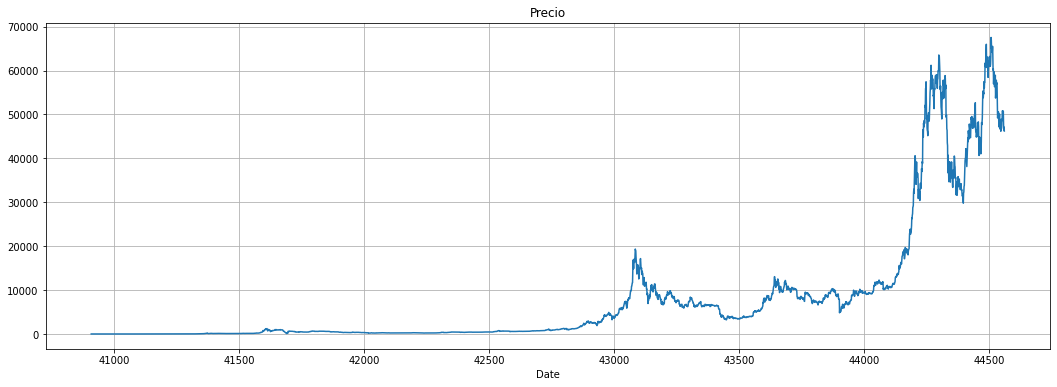

In [81]:
plt.figure(figsize=(18, 6))
data["Price"].plot()
plt.title('Precio')
plt.grid(True)
plt.show()

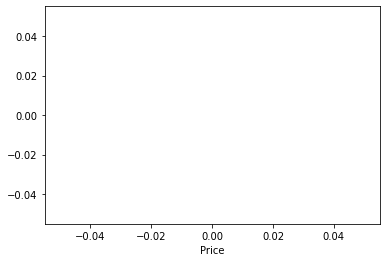

In [86]:
import seaborn as sns
sns.lineplot(data['Price'])

In [85]:
# The seasonal difference
data_diff = data - data.shift(24)
sns.lineplot(data_diff[24:], lags=60)

ValueError: ignored

It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

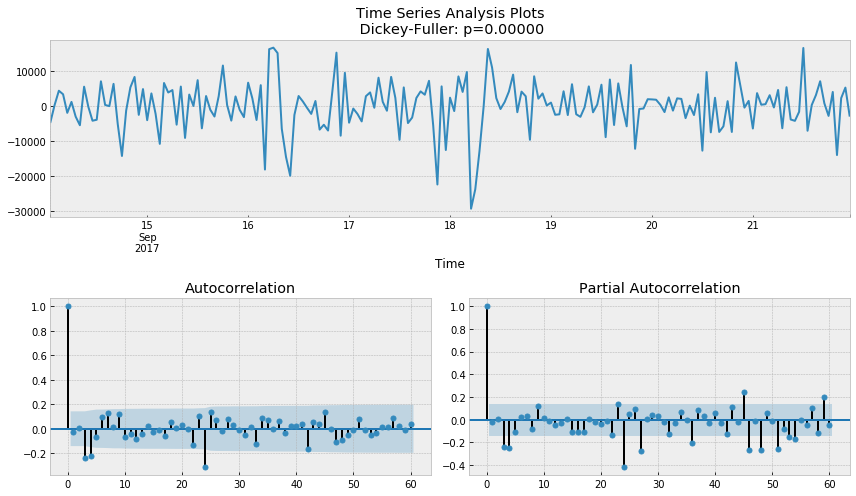

In [ ]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

## SARIMA parameters

- **p**
  is most probably 4 since it is the last significant lag on the **PACF**, after which, most others are not significant.
- d
  equals 1 because we had first differences
- **q**
  should be somewhere around 4 as well as seen on the **ACF**
- P
  might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- D
  again equals 1 because we performed seasonal differentiation
- Q
  is probably 1. The 24-th lag on ACF is significant while the 48-th is not

In [87]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [90]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [95]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(data, parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 2h 17min 54s, sys: 38min 13s, total: 2h 56min 7s
Wall time: 2h 9min 35s


In [96]:
result_table.head()

,parameters,aic
0,"(2, 2, 1, 1)",57625.257573
1,"(2, 2, 0, 1)",57633.537269
2,"(2, 3, 0, 1)",57687.497430
3,"(2, 4, 0, 1)",57689.566833
4,"(4, 2, 0, 1)",57712.775408


In [98]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Price   No. Observations:                 3653
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 24)   Log Likelihood              -28805.629
Date:                            Tue, 17 May 2022   AIC                          57625.258
Time:                                    13:06:05   BIC                          57668.633
Sample:                                         0   HQIC                         57640.709
                                           - 3653                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2637      0.001  -2408.745      0.000      -1.265      -1.263
ar.L2         -0.9999      0.000  -

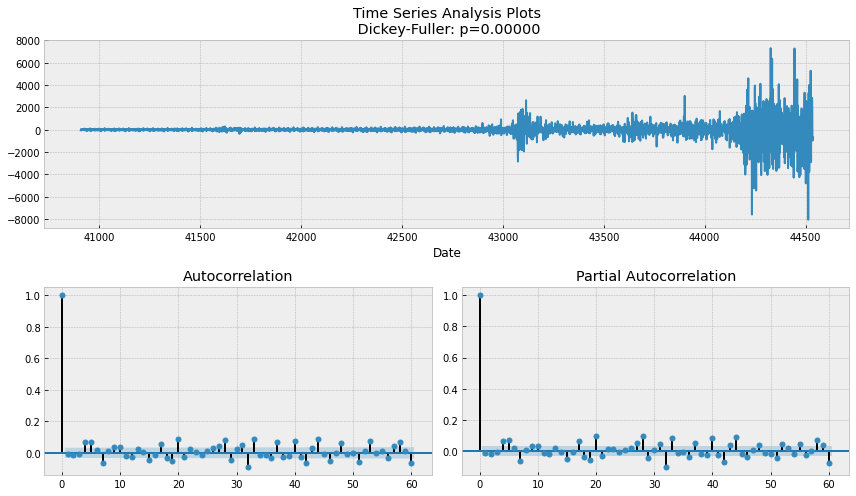

In [99]:
tsplot(best_model.resid[24+1:], lags=60)

In [100]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

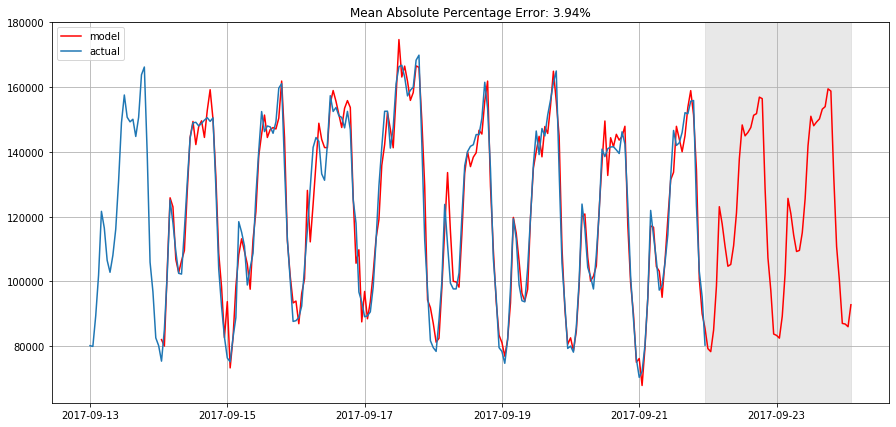

In [ ]:
plotSARIMA(ads, best_model, 50)